## Libraries

In [1]:
%matplotlib inline
%config InlineBackend.figure_formats = {'png', 'retina'}

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.style as style
import numpy as np
import seaborn as sns
import re
from bs4 import BeautifulSoup
import requests

from selenium import webdriver
import time

from sklearn import cluster, datasets
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from scipy.spatial import ConvexHull


style.use('seaborn-poster') #sets the size of the charts
style.use('ggplot')

## Web Scrapping (actas oficiales) by Selenium-Soup

In [4]:
#ACRTAS RFEF

# 1. import libraries
# 2. url: we start with the 'second' page
url = "http://actas.rfef.es/actas/RFEF_CmpJornada?cod_primaria=1000144&CodCategoria=135&CodTemporada=117&CodJornada=1"
# 3. download html with a get request
response = requests.get(url)
# 4.1. parse html (create the 'soup')
soup = BeautifulSoup(response.content, "html.parser")
# 5. find the team and the "acta"
#soup.select('span:contains("Villarreal B")')#Example
#soup.select('span:contains("Villarreal B")')[0].parent.parent.parent.parent.parent.select("td:nth-child(2) a")#Example
# 6. define function to find "acta" by team
def buscar_acta_por_equipo(equipo):
    acta = soup.select('span:contains("' + equipo + '")')[0].parent.parent.parent.parent.parent.select("td:nth-child(2) a")[0]["href"]
    root = "http://actas.rfef.es/"
    return root + acta


#Execution
path_to_chromedriver = 'chromedriver'
browser = webdriver.Chrome(executable_path = path_to_chromedriver)
browser.get(url)
browser.implicitly_wait(10)


campeonato = re.findall('2ª División B Grupo [IV]*-[A-B]', (browser.find_element_by_xpath('//*[@id="categoria"]')).text)
jornada = re.findall('Jornada \d+', (browser.find_element_by_xpath('//*[@id="jornadas"]')).text)
url_acta = buscar_acta_por_equipo("Hércules")

browser.get(url_acta)
browser.implicitly_wait(10)

acta_partido = browser.find_element_by_xpath('/html/body/table[2]/tbody/tr/td/table[4]/tbody/tr[2]/td[2]/table[4]/tbody/tr/td/a')
acta_partido.click()

acta_boton_next = browser.find_element_by_xpath('/html/body/table[2]/tbody/tr/td/center/table[9]/tbody/tr[2]/td[2]/a')
acta_boton_next.click()
SMRtable = browser.find_element_by_xpath('/html/body/table[2]/tbody/tr/td/center/table[5]')

NameError: name 'webdriver' is not defined

## Data cleansing

In [2]:
xls_away_team = pd.ExcelFile('../dataset/24_11_2020_Hercules_players.xlsx')


sheet1 = xls_away_team.parse(0)
sheet2 = xls_away_team.parse(1)

sheet1_df =pd.DataFrame(data = sheet1)
sheet2_df =pd.DataFrame(data = sheet2)

players_df_full = pd.merge(sheet1_df, sheet2_df, how='inner')
columns = players_df_full.columns
players_df_full.head()

,Unnamed: 0,Unnamed: 1,Equipo,Posición,Minutos jugados,Edad,Altura,Peso,Índice InStat,Tarjetas amarillas,...,Goles esperados,Pases,% de efectividad de pases,Pases de finalización,Centros,% de efectividad de los centros,Balones perdidos,Pérdidas en campo propio,Balones recuperados,"Robos de balón con éxito, %"
0,2,Raul Ruiz,Hercules,LD,97,30,178,66,240,-,...,-,55,85%,2,6,50%,3,-,2,50%
1,22,Acuna,Hercules,D,78,32,175,70,223,-,...,1.21,17,65%,1,2,-,4,-,2,50%
2,6,Jon Erice,Hercules,MCD,82,34,177,70,222,-,...,-,35,83%,1,-,-,5,1,4,67%
3,30,Pedro Torres Valero,Hercules,MCD,29,22,181,72,214,-,...,0.02,15,93%,-,-,-,1,-,5,-
4,28,Abdessamad,Hercules,EI,8,19,-,-,209,-,...,0.15,4,-,-,-,-,2,-,-,-


In [3]:
#Dropping 
players_df_full.drop(columns = 'Unnamed: 0', inplace = True) #we dont need the dorsal number each player
players_df_full.rename(columns={'Unnamed: 1':'Nombre'}, inplace = True)
players_df_full.set_index('Nombre', inplace=True, drop=True)
players_df_full.drop_duplicates(inplace=True)
players_df_full.replace('-',0, inplace=True)
players_df_full.sort_index(ascending = False)


,Equipo,Posición,Minutos jugados,Edad,Altura,Peso,Índice InStat,Tarjetas amarillas,Tarjetas rojas,Goles,...,Goles esperados,Pases,% de efectividad de pases,Pases de finalización,Centros,% de efectividad de los centros,Balones perdidos,Pérdidas en campo propio,Balones recuperados,"Robos de balón con éxito, %"
Nombre,,,,,,,,,,,,,,,,,,,,,
Teo Quintero Leon,Hercules,DC,118,21,188,85,192,0,0,0,...,0.00,46,83%,0,0,0,4,1,12,75%
Tano,Hercules,DC,285,30,186,76,204,0,0,0,...,0.21,119,85%,0,0,0,4,1,20,40%
Sergio Moyita,Hercules,MC,191,28,174,64,205,0,0,0,...,0.08,113,82%,2,3,67%,15,1,4,50%
Sergio Buenacasa,Hercules,D,122,24,183,75,173,0,0,1,...,1.23,17,65%,0,0,0,16,3,1,50%
Rodriguez Baldera,Hercules,EI,15,22,181,76,163,0,0,0,...,0.00,4,75%,0,1,0,0,0,0,0
Raul Ruiz,Hercules,LD,97,30,178,66,240,0,0,0,...,0.00,55,85%,2,6,50%,3,0,2,50%
Pedro Torres Valero,Hercules,MCD,29,22,181,72,214,0,0,0,...,0.02,15,93%,0,0,0,1,0,5,0
Pedro Torres,Hercules,MCD,94,22,0,0,171,0,0,0,...,0.03,31,84%,0,0,0,4,0,11,0
Pedro,Hercules,ED,117,33,175,74,180,0,0,0,...,0.16,66,62%,0,6,33%,23,1,2,67%


In [4]:
#Convert the whole columns int to float as possible
def pass_float(players_df_full):
    for i in players_df_full.columns:
        try:
            players_df_full[i] = players_df_full[i].astype(float)
        except ValueError:
            pass
    return players_df_full
players_df_full = pass_float(players_df_full) 
players_df_full.info()

<class 'pandas.core.frame.DataFrame'>
Index: 23 entries, Raul Ruiz to Rodriguez Baldera
Data columns (total 38 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Equipo                            23 non-null     object 
 1   Posición                          23 non-null     object 
 2   Minutos jugados                   23 non-null     float64
 3   Edad                              23 non-null     float64
 4   Altura                            23 non-null     float64
 5   Peso                              23 non-null     float64
 6   Índice InStat                     23 non-null     float64
 7   Tarjetas amarillas                23 non-null     float64
 8   Tarjetas rojas                    23 non-null     float64
 9   Goles                             23 non-null     float64
 10  Asistencias                       23 non-null     float64
 11  Entradas                          23 non-null     float

In [5]:
#There're a few object that contain floats and string (because the %), so lets get theses columns and afterwards eliminate the '%' to convert it as float
def get_columns_str(players_df_full):
    list_columns_str = []
    for i in players_df_full.columns:
        if players_df_full[i].dtype == object:
            list_columns_str.append(i)
    return list_columns_str
list_columns_str = get_columns_str(players_df_full)

In [6]:
#Eliminate the class str which contains values with '%' in the df

for percentage in list_columns_str:
    j=0 #we reset the counter when we change the column
    for i in players_df_full[percentage]:
        if type(i) == str: #we only need the str
            if re.search('[+%]', i): #looking '%' inside the str
                players_df_full[percentage][j] = float(i.strip('%'))
                
        j = j+1
players_df_full = pass_float(players_df_full)

C:\Users\Espadas\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [7]:
#There's 0 values in  the weight or height, should convert them by the meaning of the group
mean_peso = round(players_df_full[players_df_full['Peso'] != 0]['Peso'].mean())
mean_altura = round(players_df_full[players_df_full['Altura'] != 0]['Altura'].mean())
players_df_full.loc[players_df_full['Peso'] == 0, 'Peso'] = mean_peso
players_df_full.loc[players_df_full['Altura'] == 0, 'Altura'] = mean_altura

In [ ]:
#convert into excel file to posterior analyze in Tableau

players_df.to_excel("../dataset/Away_team.xlsx",
             sheet_name='Sheet_name_1')

## Construct Data Frames to analyze the most challengers

In [8]:
players_df = players_df_full.copy()

#age_yellow_red_home_team = dict_scrapping_team(url = url_ibiza, browser = browser)
#age_yellow_red_away_team = dict_scrapping_team(url = url_hercules, browser = browser)

challengers = pd.DataFrame(data = players_df_full, columns =('Posición','Edad','Altura','Peso', 'Entradas', 'Disputas', 'Faltas','Balones perdidos', 'Balones recuperados'))
challengers.head()

,Posición,Edad,Altura,Peso,Entradas,Disputas,Faltas,Balones perdidos,Balones recuperados
Nombre,,,,,,,,,
Raul Ruiz,LD,30.0,178.0,66.0,2.0,10.0,4.0,3.0,2.0
Acuna,D,32.0,175.0,70.0,2.0,24.0,0.0,4.0,2.0
Jon Erice,MCD,34.0,177.0,70.0,3.0,9.0,0.0,5.0,4.0
Pedro Torres Valero,MCD,22.0,181.0,72.0,0.0,10.0,0.0,1.0,5.0
Abdessamad,EI,19.0,179.0,72.0,0.0,2.0,0.0,2.0,0.0


## Scaling

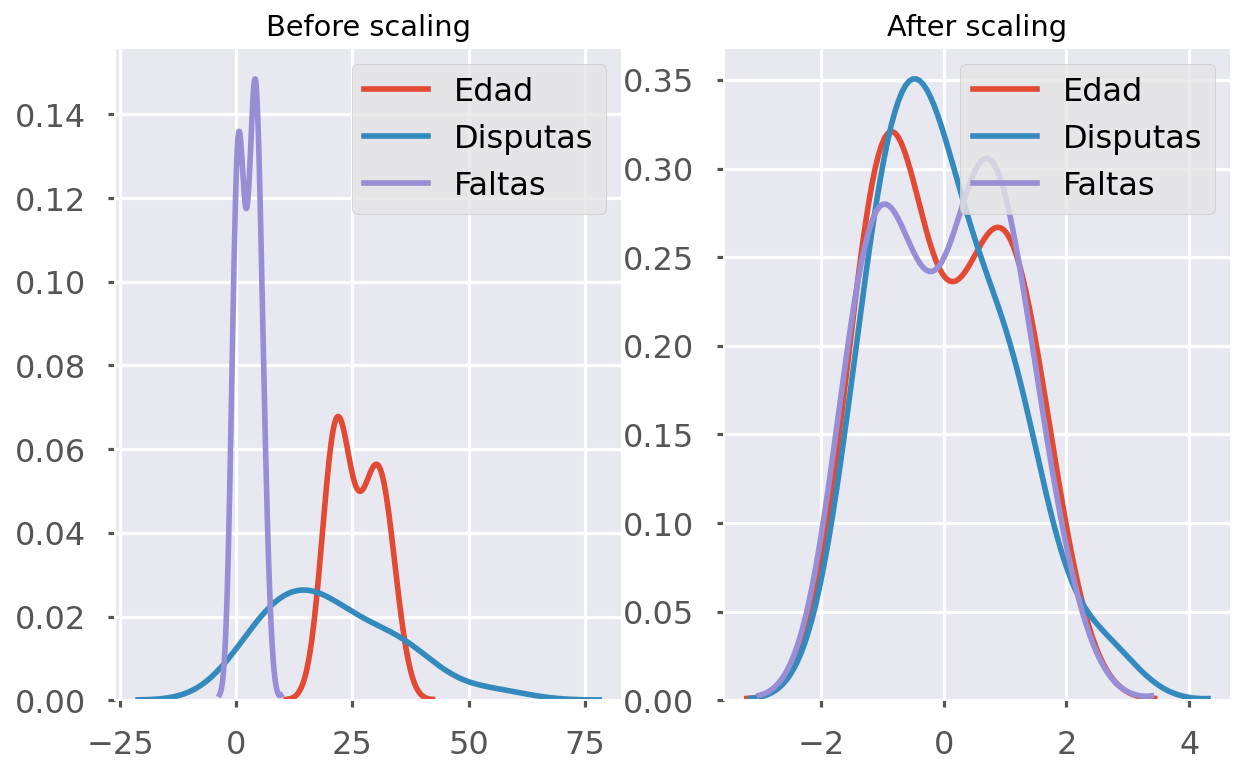

<Figure size 921.6x633.6 with 0 Axes>

In [10]:
#---The whole variables team
#list_columns_str = get_columns_str(players_df_full) #reset the columns with str
#scaled_features = StandardScaler().fit_transform(players_df.drop(columns = (list_columns_str), axis=1))
#players_df_scaled = pd.DataFrame(scaled_features, index=players_df.drop(columns=(list_columns_str)).index, columns=players_df.drop(columns=(list_columns_str)).columns)


#Challengers
list_columns_str = get_columns_str(challengers) #reset the columns with str
scaled_features = StandardScaler().fit_transform(challengers.drop(columns = (list_columns_str), axis=1))
players_df_scaled = pd.DataFrame(scaled_features, index=challengers.drop(columns=(list_columns_str)).index, columns=challengers.drop(columns=(list_columns_str)).columns)


#Plotting sns
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 6))
ax1.set_facecolor('#E8E8F1')
ax2.set_facecolor('#E8E8F1')

ax1.set_title('Before scaling')
sns.kdeplot(players_df['Edad'], ax=ax1)
sns.kdeplot(players_df['Disputas'], ax=ax1)
sns.kdeplot(players_df['Faltas'], ax=ax1)
ax2.set_title('After scaling')
sns.kdeplot(players_df_scaled['Edad'], ax=ax2)
sns.kdeplot(players_df_scaled['Disputas'], ax=ax2)
sns.kdeplot(players_df_scaled['Faltas'], ax=ax2)
plt.show()
plt.savefig('../Technical_report/images/scaling_away_team.png', dpi=None, bbox_inches="tight")  


In [9]:
#posicion = players_df['Posición'].values
#players_df["Posición_categoria"] = players_df.apply(lambda x: 'Defensa' if  x['Posición'] in ['LD','LI','D']else \
#                    ('Mediocentro' if x['Posición'] in ['MC','MCD','MCI'] else 'Delantero'), axis=1)


## Correlation Matrix

In [10]:
#COR whole variables team
#sns.heatmap(players_df_scaled.corr())
#plt.title("Correlation matrix")
#plt.show()

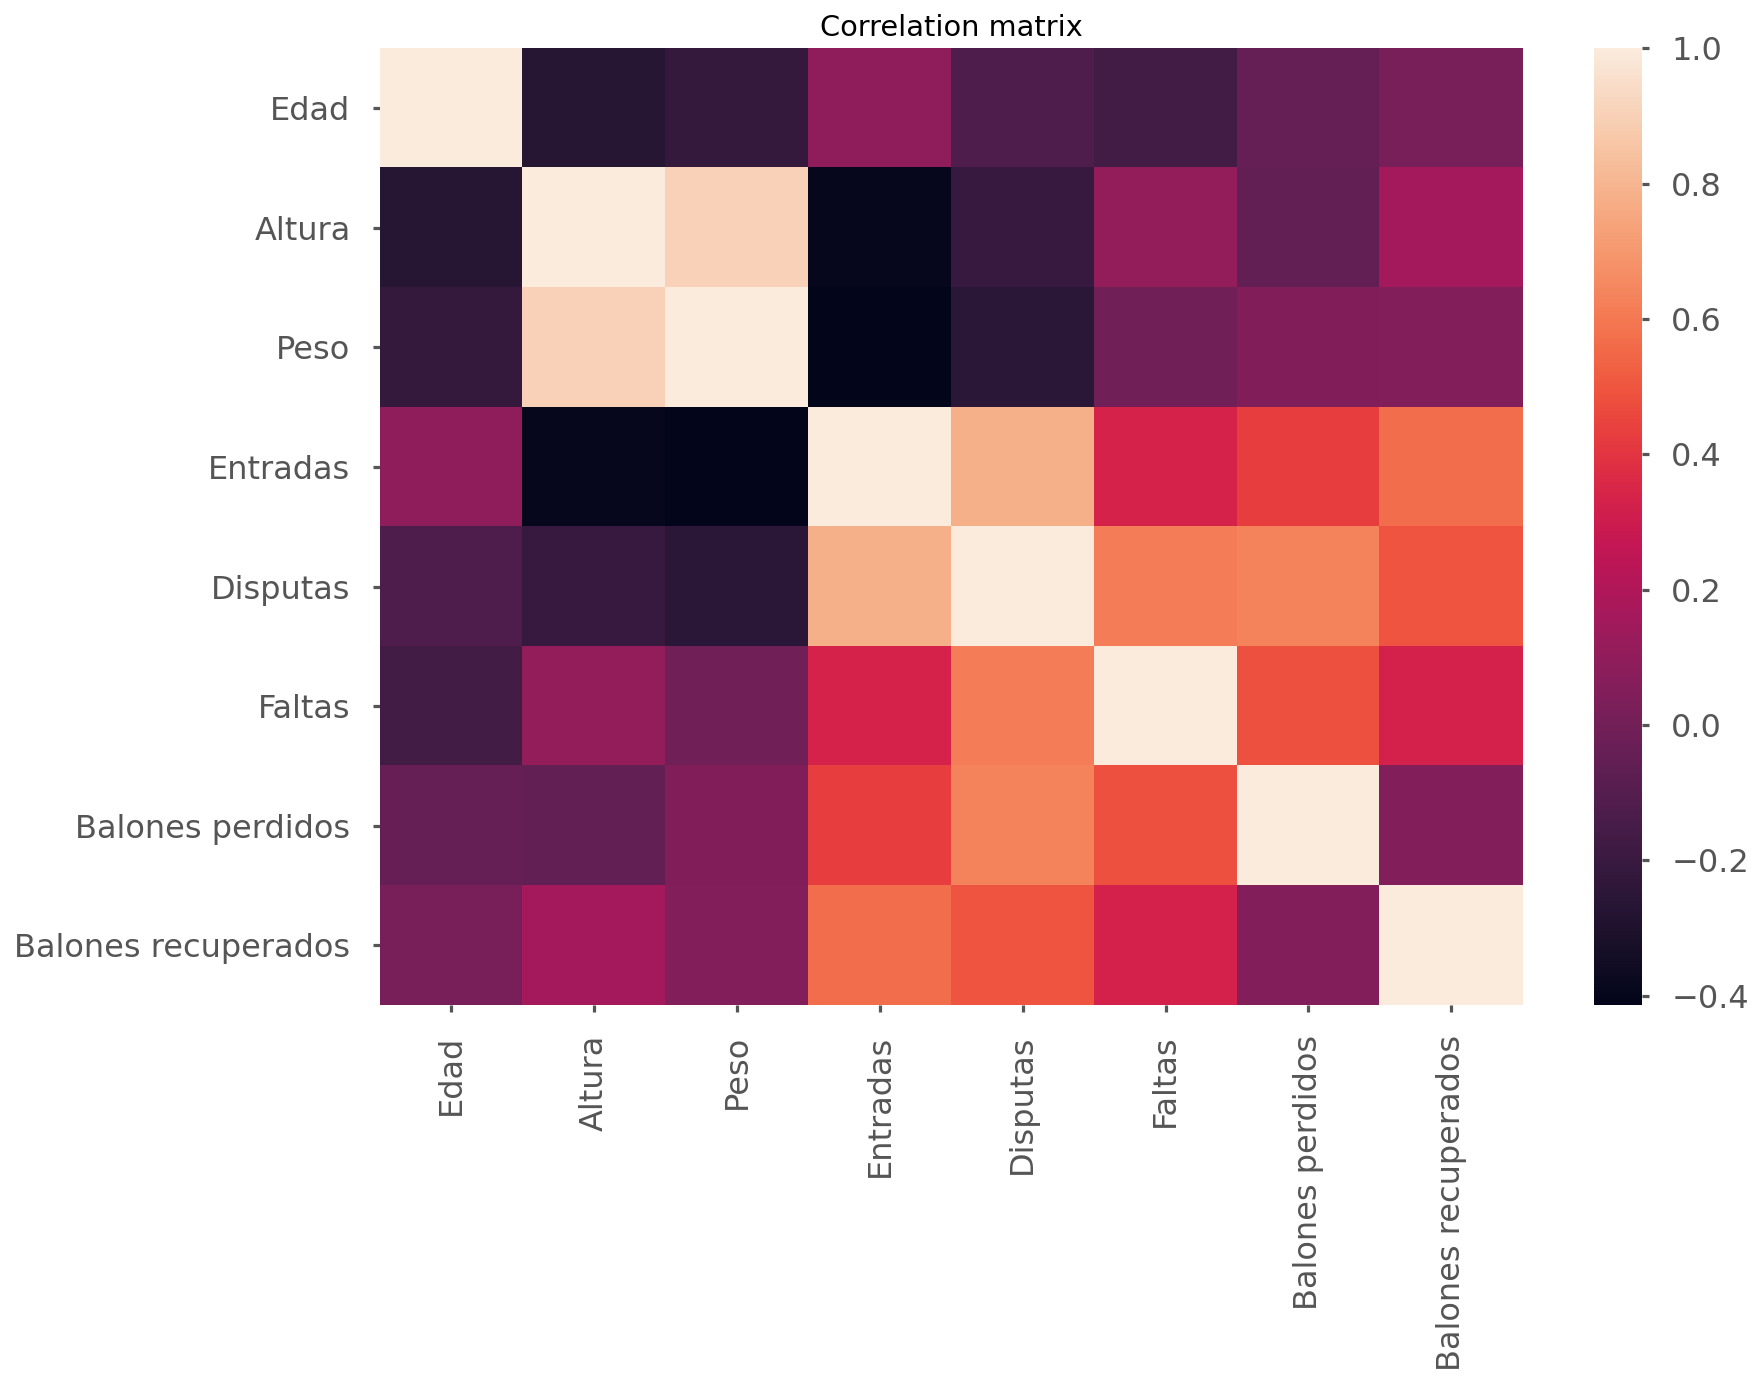

<Figure size 921.6x633.6 with 0 Axes>

In [11]:
#COR callengers variables team
sns.heatmap(challengers.corr())
plt.title("Correlation matrix")
plt.show()
plt.savefig('../Technical_report/images/cor_away_team.png', dpi=None, bbox_inches="tight")  

## Simplifying the features

In [12]:
##THE WHOLE TEAM

# # Create features PC1 and PC2 using PCA
# features_pca = PCA(n_components = 2).fit_transform(players_df_scaled)
# principal_df = pd.DataFrame(features_pca, index=players_df_scaled.index, columns=["PC1", "PC2"])

# # Plotting 
# fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15, 8))

# ax1.set_facecolor('#E8E8F1')
# ax2.set_facecolor('#E8E8F1')

# ax1.set_xlabel('CP1', fontsize=18)
# ax1.set_ylabel('CP2', fontsize=18)
# ax2.set_xlabel('CP1', fontsize=18)
# ax2.set_ylabel('CP2', fontsize=18)

# pos_colors = {
#     'Defensa': 'red',
#     'Mediocentro': 'yellow',
#     'Delantero': 'green'
# }

# ax1.scatter(principal_df['PC1'], principal_df['PC2'], marker='o', s=50, alpha=0.5, cmap='viridis')
# ax2.scatter(principal_df['PC1'], principal_df['PC2'], c=players_df['Posición_categoria'].apply(lambda x: pos_colors[x]), marker='o', s=50, alpha=0.5, cmap='viridis')

# texts = [plt.text(principal_df['PC1'][name], principal_df['PC2'][name], name) for name in principal_df.index]


# plt.tight_layout()
# plt.show()

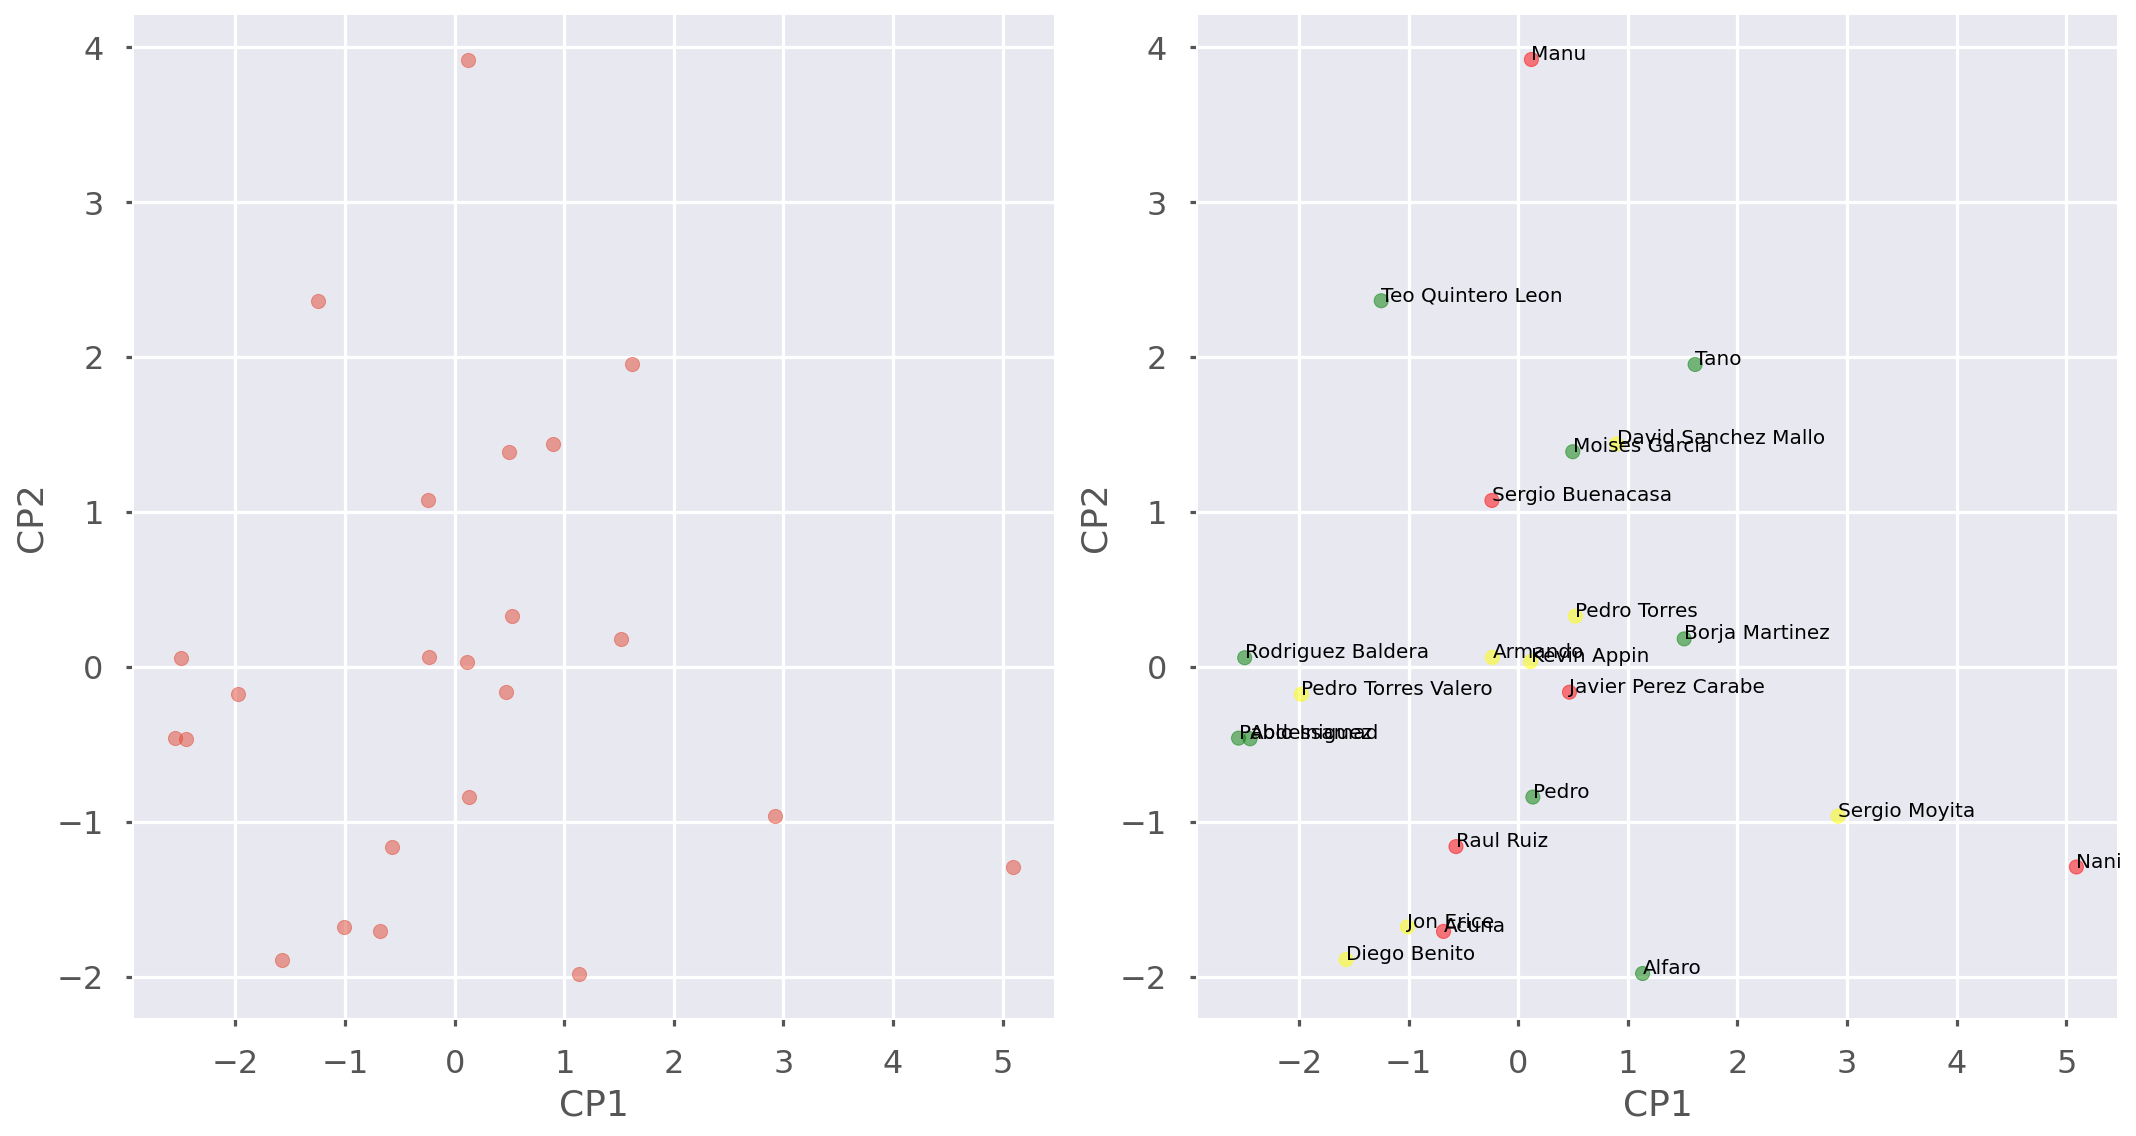

<Figure size 921.6x633.6 with 0 Axes>

In [13]:
# Create features PC1 and PC2 using PCA
features_pca = PCA(n_components = 2).fit_transform(players_df_scaled)
principal_df = pd.DataFrame(features_pca, index=players_df_scaled.index, columns=["PC1", "PC2"])

#Simplyfying the position each player 
posicion = challengers['Posición'].values
challengers["Posición_categoria"] = challengers.apply(lambda x: 'Defensa' if  x['Posición'] in ['LD','LI','D']else \
                     ('Mediocentro' if x['Posición'] in ['MC','MCD','MCI'] else 'Delantero'), axis=1)

# Plotting 
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15, 8))

ax1.set_facecolor('#E8E8F1')
ax2.set_facecolor('#E8E8F1')

ax1.set_xlabel('CP1', fontsize=18)
ax1.set_ylabel('CP2', fontsize=18)
ax2.set_xlabel('CP1', fontsize=18)
ax2.set_ylabel('CP2', fontsize=18)

pos_colors = {
    'Defensa': 'red',
    'Mediocentro': 'yellow',
    'Delantero': 'green'
}

ax1.scatter(principal_df['PC1'], principal_df['PC2'], marker='o', s=50, alpha=0.5, cmap='viridis')
ax2.scatter(principal_df['PC1'], principal_df['PC2'], c=challengers['Posición_categoria'].apply(lambda x: pos_colors[x]), marker='o', s=50, alpha=0.5, cmap='viridis')

texts = [plt.text(principal_df['PC1'][name], principal_df['PC2'][name], name) for name in principal_df.index]
#adjust_text(texts, arrowprops=dict(arrowstyle='->', color='#999999'))

plt.tight_layout()
plt.show()
plt.savefig('../Technical_report/images/pca_away_team.png', dpi=None, bbox_inches="tight")  

## Clustering K-Means

QhullError: QH6214 qhull input error: not enough points(2) to construct initial simplex (need 3)

While executing:  | qhull i Qt
Options selected for Qhull 2019.1.r 2019/06/21:
  run-id 935050900  incidence  Qtriangulate  _pre-merge  _zero-centrum
  _maxoutside  0


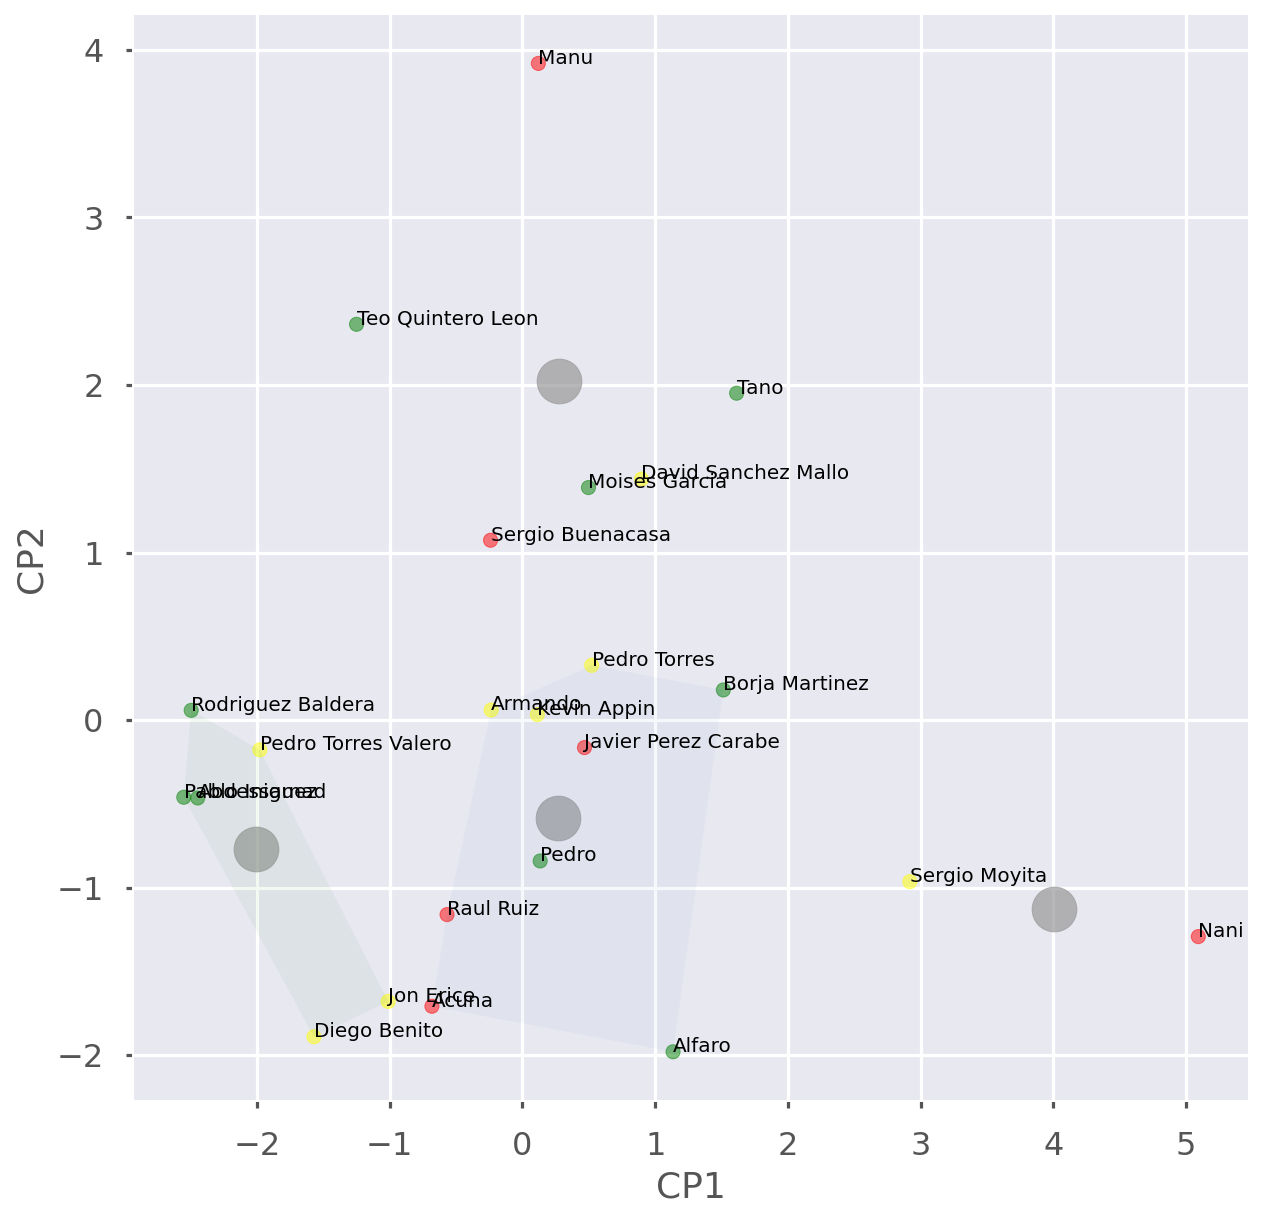

In [14]:
# Create clusters for challengers
n_clusters = 4
kmeans = cluster.KMeans(n_clusters)
y_kmeans = kmeans.fit_predict(principal_df)

# Draw clusters
plt.figure(figsize=(10, 10))
ax = plt.axes()
ax.set_facecolor('#E8E8F1')
plt.xlabel('CP1', fontsize=18)
plt.ylabel('CP2', fontsize=18)

pos_colors = {
    'Defensa': 'red',
    'Mediocentro': 'yellow',
    'Delantero': 'green'
}
plt.scatter(principal_df['PC1'], principal_df['PC2'], marker='o', c=challengers['Posición_categoria'].apply(lambda x: pos_colors[x]), cmap="Paired", s=50, alpha=0.5)

# Draw centers
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], marker='o', c='#999999', s=500, alpha=0.7)
texts = [plt.text(principal_df['PC1'][name], principal_df['PC2'][name], name) for name in principal_df['PC1'].index]


# Draw poligons around clusters
# https://www.machinelearningplus.com/plots/top-50-matplotlib-visualizations-the-master-plots-python/
def encircle(x,y, ax=None, **kw):
    if not ax: ax=plt.gca()
    p = np.c_[x,y]
    hull = ConvexHull(p)
    poly = plt.Polygon(p[hull.vertices,:], **kw)
    ax.add_patch(poly)


# Draw polygon surrounding vertices
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']
for i in y_kmeans:
    encircle(principal_df.loc[kmeans.labels_ == i, 'PC1'], principal_df.loc[kmeans.labels_ == i, 'PC2'], ec="k", fc=colors[i], alpha=0.02, linewidth=0)

plt.savefig('../Technical_report/images/cluster_away_team.png', dpi=None, bbox_inches="tight")  